# Remote Worker Productivity Prediction

In [239]:
import os
import pickle
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
import matplotlib.pyplot as plt
print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 1. Get data

In [240]:
# Load data
print("🛫 Loading dataset...")
df = pd.read_csv('data/remote_worker_productivity_1000.csv')
print(f"Dataset shape: {df.shape}")

# Basic info
print("\n📋 Dataset Info:")
print("=" * 40)
print(df.info())

print("\n🔍 Missing Values:")
print("=" * 40)
print(df.isnull().sum())

🛫 Loading dataset...
Dataset shape: (1000, 17)

📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   worker_id                 1000 non-null   object 
 1   location_type             1000 non-null   object 
 2   industry_sector           1000 non-null   object 
 3   age                       1000 non-null   int64  
 4   experience_years          1000 non-null   int64  
 5   average_daily_work_hours  1000 non-null   float64
 6   break_frequency_per_day   1000 non-null   int64  
 7   task_completion_rate      1000 non-null   float64
 8   late_task_ratio           1000 non-null   float64
 9   calendar_scheduled_usage  1000 non-null   float64
 10  focus_time_minutes        1000 non-null   float64
 11  tool_usage_frequency      1000 non-null   int64  
 12  automated_task_count      1000 non-null   int64  
 13  

In [241]:
# Display first few rows
print("📊 First 5 rows:")
df.head()

📊 First 5 rows:


,worker_id,location_type,industry_sector,age,experience_years,average_daily_work_hours,break_frequency_per_day,task_completion_rate,late_task_ratio,calendar_scheduled_usage,focus_time_minutes,tool_usage_frequency,automated_task_count,AI_assisted_planning,real_time_feedback_score,productivity_label,productivity_score
0,W0001,Village,Healthcare,23,26,7.45,1,66.377024,0.254624,55.496926,106.0,19,13,0,80,Low,32.31
1,W0002,City,Healthcare,27,27,9.82,3,88.226501,0.173382,66.496755,141.0,5,1,1,83,Medium,41.09
2,W0003,Village,Retail,30,8,7.38,2,67.004170,0.351835,41.367064,92.0,4,4,0,81,Low,25.69
3,W0004,Village,Finance,54,19,8.37,1,66.004424,0.347840,51.086805,94.0,17,9,1,84,Low,31.98
4,W0005,City,Education,46,1,7.51,4,91.468942,0.085582,93.618344,202.0,14,8,0,64,High,48.19


## 2. Data Cleaning

In [242]:
# Standardize column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Target variable
TARGET = "productivity_score"

# Drop identifier and leakage columns
drop_cols = ["worker_id", "productivity_label"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Categorical features
categorical_col = [
    "location_type",
    "industry_sector"
]

# Numerical features
numerical_col = [
    "age",
    "experience_years",
    "average_daily_work_hours",
    "break_frequency_per_day",
    "late_task_ratio",
    "calendar_scheduled_usage",
    "focus_time_minutes",
    "tool_usage_frequency",
    "automated_task_count",
    "ai_assisted_planning",
    "real_time_feedback_score",
]


# Keep only modeling columns
df = df[categorical_col + numerical_col + [target_col]].copy()

# Handle missing values
df = df.dropna()

print("📊 Feature Summary:")
print("=" * 50)
print(f"Total features: {len(numerical_col) + len(categorical_col)}")
print(f"Numerical features: {len(numerical_col)}")
print(f"Categorical features: {len(categorical_col)}")
print(f"Target: {target_col}")
df.head()

📊 Feature Summary:
Total features: 13
Numerical features: 11
Categorical features: 2
Target: productivity_score


,location_type,industry_sector,age,experience_years,average_daily_work_hours,break_frequency_per_day,late_task_ratio,calendar_scheduled_usage,focus_time_minutes,tool_usage_frequency,automated_task_count,ai_assisted_planning,real_time_feedback_score,productivity_score
0,Village,Healthcare,23,26,7.45,1,0.254624,55.496926,106.0,19,13,0,80,32.31
1,City,Healthcare,27,27,9.82,3,0.173382,66.496755,141.0,5,1,1,83,41.09
2,Village,Retail,30,8,7.38,2,0.351835,41.367064,92.0,4,4,0,81,25.69
3,Village,Finance,54,19,8.37,1,0.347840,51.086805,94.0,17,9,1,84,31.98
4,City,Education,46,1,7.51,4,0.085582,93.618344,202.0,14,8,0,64,48.19


# 3. Split Dataset

In [243]:
# Split the data into training, validation, and test sets
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

# Print the sizes of each dataset
len(df_train), len(df_val), len(df_test)

(600, 200, 200)

In [244]:
# Reset the index for all split datasets to avoid index conflicts
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

In [245]:
print("Train size:", df_train.shape)
print("Validation size:", df_val.shape)
print("Test size:", df_test.shape)
print("Full Train size:", df_full_train.shape)

Train size: (600, 14)
Validation size: (200, 14)
Test size: (200, 14)
Full Train size: (800, 14)


In [246]:
# Extract target variable (y) from each dataset
y_train = df_train.productivity_score.values
y_val = df_val.productivity_score.values
y_test = df_test.productivity_score.values

# Remove the target column from feature sets
del df_train["productivity_score"]
del df_val["productivity_score"]
del df_test["productivity_score"]

In [247]:
df_train

,location_type,industry_sector,age,experience_years,average_daily_work_hours,break_frequency_per_day,late_task_ratio,calendar_scheduled_usage,focus_time_minutes,tool_usage_frequency,automated_task_count,ai_assisted_planning,real_time_feedback_score
0,City,IT,46,11,7.22,5,0.327048,50.141717,78.0,1,12,0,82
1,City,IT,52,23,8.86,4,0.394658,33.321814,105.0,10,0,0,98
2,Village,Healthcare,58,16,7.14,2,0.079591,89.501580,227.0,10,12,1,80
3,City,Finance,43,32,9.19,3,0.094234,99.726337,213.0,4,3,1,98
4,Village,IT,53,31,5.50,5,0.109137,68.147941,123.0,18,4,0,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Village,Retail,30,34,8.68,1,0.040625,95.420767,196.0,13,5,0,76
596,Village,Education,52,1,7.87,2,0.313835,45.935198,63.0,10,9,0,68
597,Town,Healthcare,29,14,6.65,1,0.219628,62.927171,139.0,13,10,0,92
598,Town,Retail,41,21,5.97,5,0.047032,97.471506,220.0,11,6,1,97


# 4. EDA

In [248]:
df_full_train.dtypes

location_type                object
industry_sector              object
age                           int64
experience_years              int64
average_daily_work_hours    float64
break_frequency_per_day       int64
late_task_ratio             float64
calendar_scheduled_usage    float64
focus_time_minutes          float64
tool_usage_frequency          int64
automated_task_count          int64
ai_assisted_planning          int64
real_time_feedback_score      int64
productivity_score          float64
dtype: object

In [249]:
# Numerical features analysis
df_full_train[numerical_col].describe()

,age,experience_years,average_daily_work_hours,break_frequency_per_day,late_task_ratio,calendar_scheduled_usage,focus_time_minutes,tool_usage_frequency,automated_task_count,ai_assisted_planning,real_time_feedback_score
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,40.536250,17.845000,7.499887,2.978750,0.183341,67.490003,149.275000,9.417500,7.110000,0.491250,74.087500
std,10.885969,9.794304,1.203708,1.438188,0.119570,19.980928,52.584106,5.885065,4.243573,0.500236,14.138944
min,22.000000,1.000000,3.610000,1.000000,0.000808,30.090528,60.000000,0.000000,0.000000,0.000000,50.000000
25%,31.000000,9.750000,6.700000,2.000000,0.073417,49.557422,104.000000,4.000000,4.000000,0.000000,62.000000
50%,41.000000,18.000000,7.515000,3.000000,0.174453,68.760631,148.500000,9.000000,7.000000,0.000000,74.000000
75%,50.000000,26.000000,8.312500,4.000000,0.291497,85.372089,197.000000,15.000000,11.000000,1.000000,86.000000
max,59.000000,34.000000,11.250000,5.000000,0.399570,99.994153,239.000000,19.000000,14.000000,1.000000,99.000000


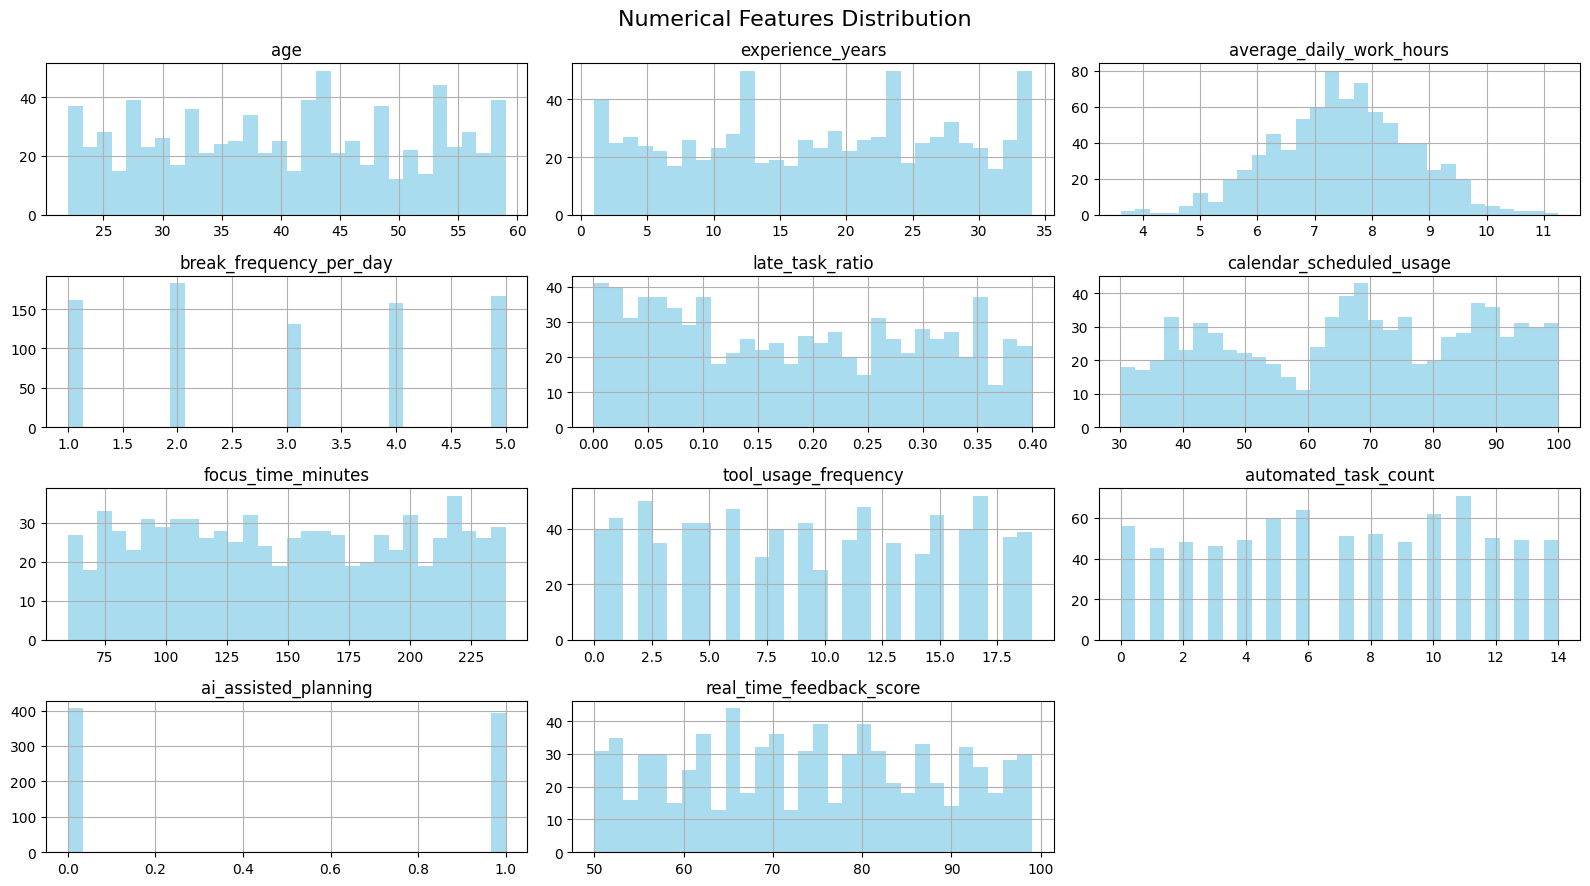

In [250]:
# Numerical features distributions
df_full_train[numerical_col].hist(bins=30, figsize=(16, 9), color='skyblue', alpha=0.7)
plt.suptitle('Numerical Features Distribution', fontsize=16)
plt.tight_layout()
plt.show()


🎯 Target Variable Summary:
count    800.000000
mean      38.901612
std        8.821001
min       20.560000
25%       30.190000
50%       39.385000
75%       47.630000
max       55.200000
Name: productivity_score, dtype: float64

Percentiles:
0.01    23.4489
0.05    25.6895
0.10    27.0470
0.25    30.1900
0.50    39.3850
0.75    47.6300
0.90    50.3740
0.95    51.1015
0.99    52.2802
Name: productivity_score, dtype: float64


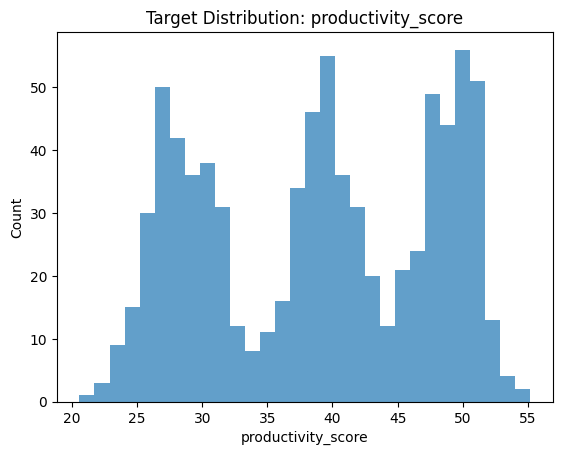

In [251]:
# 🎯 Target Variable Analysis

print("\n🎯 Target Variable Summary:")
print("=" * 40)

print(df_full_train["productivity_score"].describe())

# Percentile analysis (more informative than value_counts for continuous targets)
percentiles = df_full_train["productivity_score"].quantile(
    [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
)
print("\nPercentiles:")
print(percentiles)

# Distribution plot
plt.figure()
plt.hist(df_full_train["productivity_score"], bins=30, alpha=0.7)
plt.title("Target Distribution: productivity_score")
plt.xlabel("productivity_score")
plt.ylabel("Count")
plt.show()


/tmp/ipykernel_2274/2214288502.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index, rotation=45)
/tmp/ipykernel_2274/2214288502.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index, rotation=45)


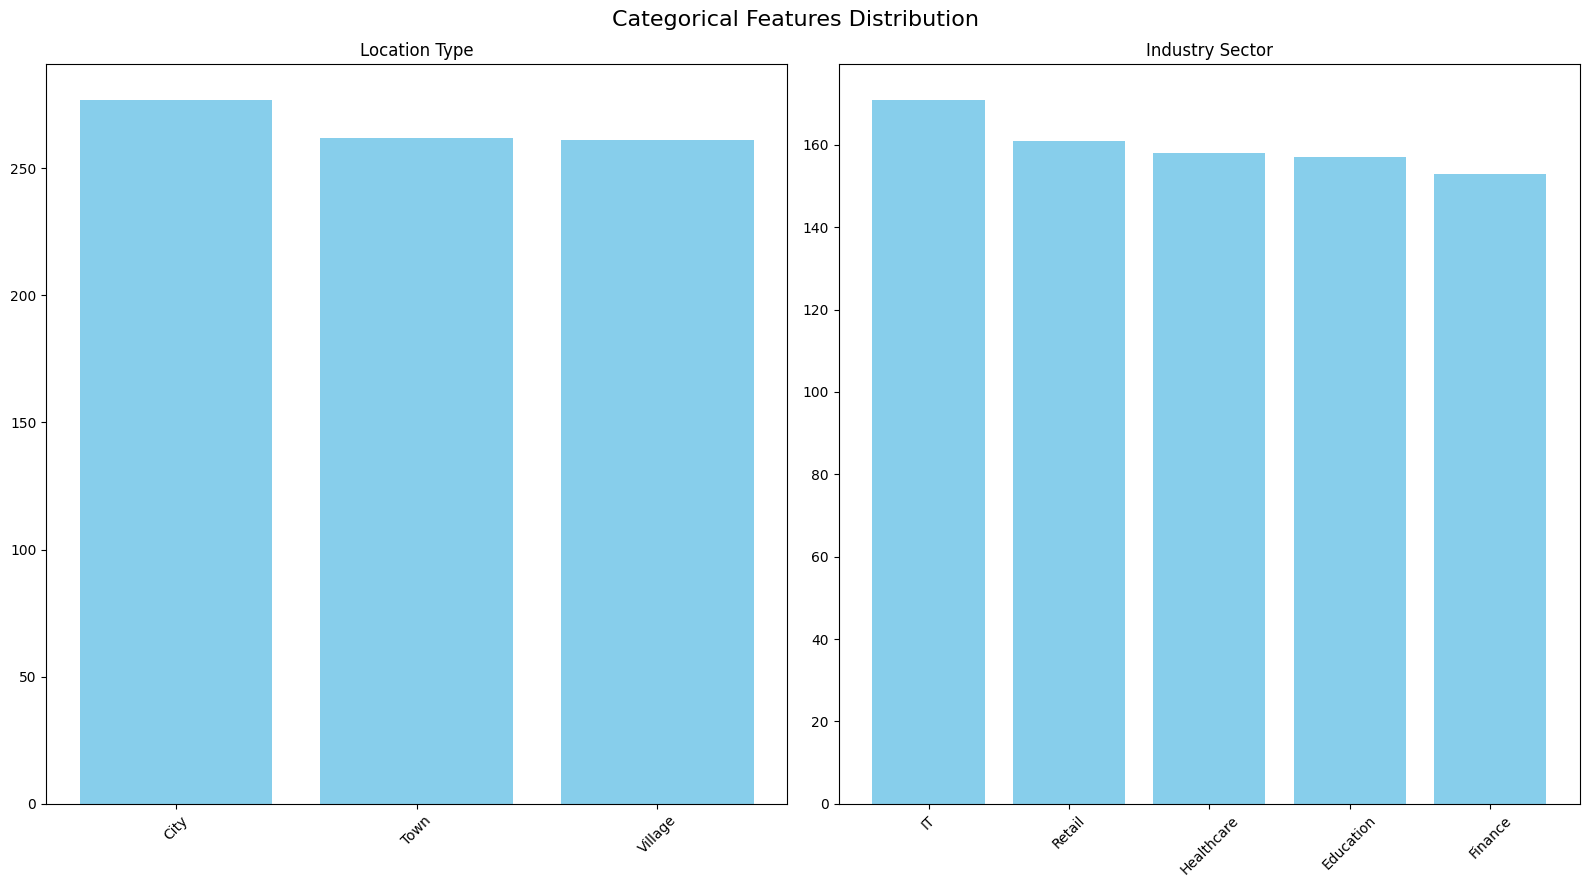

In [252]:
# Categorical features
fig, axes = plt.subplots(1, 2, figsize=(16, 9))

for i, col in enumerate(categorical_col):
    ax = axes.flat[i]
    counts = df_full_train[col].value_counts()
    ax.bar(counts.index, counts.values, color='skyblue')
    ax.set_title(col.replace('_', ' ').title())
    ax.set_xticklabels(counts.index, rotation=45)
    
plt.suptitle('Categorical Features Distribution', fontsize=16)
plt.tight_layout()
plt.show()

## Feature Importance: Satisfaction Rate and Risk Ratio

In [253]:
global_productivity = df_full_train.productivity_score.mean()
for c in categorical_col:
    print(c)
    df_group = df_full_train.groupby(c).productivity_score.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_productivity
    df_group['risk'] = df_group['mean'] / global_productivity
    display(df_group)
    print()
    print()

location_type


,mean,count,diff,risk
location_type,,,,
City,39.799206,277,0.897593,1.023073
Town,38.260496,262,-0.641116,0.983520
Village,38.592567,261,-0.309045,0.992056




industry_sector


,mean,count,diff,risk
industry_sector,,,,
Education,38.817452,157,-0.084160,0.997837
Finance,38.786601,153,-0.115011,0.997044
Healthcare,39.172658,158,0.271046,1.006967
IT,39.728655,171,0.827042,1.021260
Retail,37.948571,161,-0.953041,0.975501


## Feature Importance: Correlation

In [254]:
df_full_train[numerical_col].corrwith(df_full_train.productivity_score).sort_values()

late_task_ratio            -0.926086
break_frequency_per_day    -0.038553
age                        -0.035046
experience_years            0.005145
real_time_feedback_score    0.007602
automated_task_count        0.010371
average_daily_work_hours    0.027875
ai_assisted_planning        0.161858
tool_usage_frequency        0.177242
focus_time_minutes          0.911101
calendar_scheduled_usage    0.961660
dtype: float64

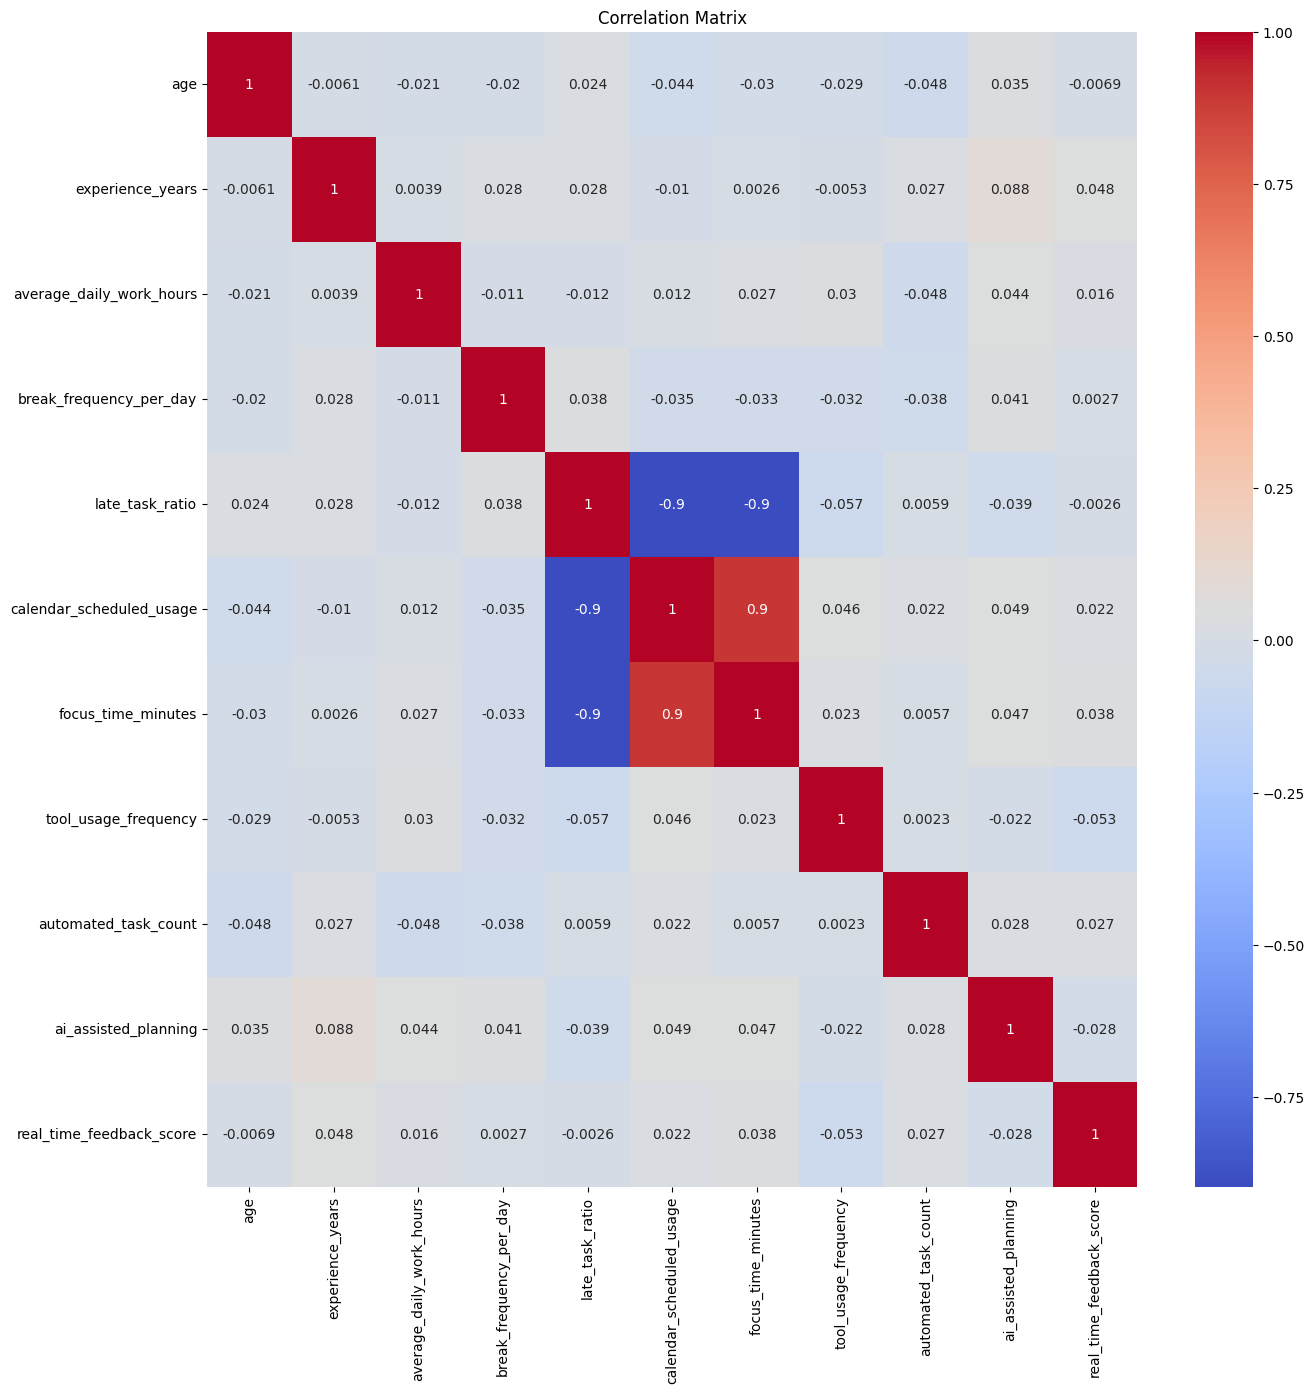

In [255]:
plt.figure(figsize=(15,15))
sns.heatmap(df_full_train[numerical_col].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 4. One-hot Encoding

In [256]:
print("🔢 Applying DictVectorizer...")
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_col + numerical_col].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_col + numerical_col].to_dict(orient='records')
X_val = dv.transform(val_dict)
test_dict = df_test[categorical_col + numerical_col].to_dict(orient='records')
X_test = dv.transform(test_dict)

🔢 Applying DictVectorizer...


In [257]:
# Column names after one-hot encoding
feature_names = dv.get_feature_names_out()
feature_names

array(['age', 'ai_assisted_planning', 'automated_task_count',
       'average_daily_work_hours', 'break_frequency_per_day',
       'calendar_scheduled_usage', 'experience_years',
       'focus_time_minutes', 'industry_sector=Education',
       'industry_sector=Finance', 'industry_sector=Healthcare',
       'industry_sector=IT', 'industry_sector=Retail', 'late_task_ratio',
       'location_type=City', 'location_type=Town',
       'location_type=Village', 'real_time_feedback_score',
       'tool_usage_frequency'], dtype=object)

# 5. Models

## Linear Regression

In [258]:
# Linear Regression
print("\n🔹 Training Linear Regression...")
lr = LinearRegression()

# Train the model on training data
lr.fit(X_train, y_train)

# Predict on validation set
val_pred_lr = lr.predict(X_val)

# Evaluate performance using RMSE
rmse_lr = np.sqrt(mean_squared_error(y_val, val_pred_lr))

rmse_lr



🔹 Training Linear Regression...


np.float64(1.3741511627470426)

## Ridge Regression

In [259]:
# Ridge Regression
print("🔹 Training Ridge Regression...")
# Ridge regression adds L2 regularization
ridge = Ridge(alpha=1.0)

ridge.fit(X_train, y_train)

val_pred_ridge = ridge.predict(X_val)
rmse_ridge = np.sqrt(mean_squared_error(y_val, val_pred_ridge))

rmse_ridge


🔹 Training Ridge Regression...


np.float64(1.4315722088885763)

## Random Forest

In [260]:
# Random Forest Regressor
print("🔹 Training Random Forest...")
rf = RandomForestRegressor(
    n_estimators=300,     # number of trees
    random_state=42,
    n_jobs=-1             # use all available CPU cores
)

# Train the model
rf.fit(X_train, y_train)

# Validation prediction
val_pred_rf = rf.predict(X_val)

# Validation RMSE
rmse_rf = np.sqrt(mean_squared_error(y_val, val_pred_rf))

rmse_rf


🔹 Training Random Forest...


np.float64(1.304227754019812)

## Model Comparison

In [261]:
# Model Comparison
print("\n📊 Validation RMSE:")
results = pd.DataFrame({
    "model": [
        "Linear Regression",
        "Ridge Regression",
        "Random Forest"
    ],
    "validation_rmse": [
        rmse_lr,
        rmse_ridge,
        rmse_rf
    ]
}).sort_values("validation_rmse")

results



📊 Validation RMSE:


,model,validation_rmse
2,Random Forest,1.304228
0,Linear Regression,1.374151
1,Ridge Regression,1.431572


## Final Evaluation on Test Set

In [262]:
# Final Evaluation on Test Set

# Select the best model
best_model = rf
print("\n✅ Selected model: Random Forest")

# Final test evaluation
print("\n🧪 Evaluating on test set...")
test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

test_rmse



✅ Selected model: Random Forest

🧪 Evaluating on test set...


np.float64(1.3529267483311893)

## Feature Importance

In [263]:
# Feature Importance Analysis


fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi.head(15)



,feature,importance
5,calendar_scheduled_usage,0.781621
13,late_task_ratio,0.111533
7,focus_time_minutes,0.067862
18,tool_usage_frequency,0.019469
1,ai_assisted_planning,0.007659
17,real_time_feedback_score,0.001940
6,experience_years,0.001875
3,average_daily_work_hours,0.001765
0,age,0.001720
2,automated_task_count,0.001546


# 6. Save model

In [264]:
print("\n💾 Saving model")
with open("model.bin", "wb") as f:
        pickle.dump(
        {"model": best_model,
         "dv": dv
        },f
        )


💾 Saving model
